Structural lines: 36
Textural lines: 362


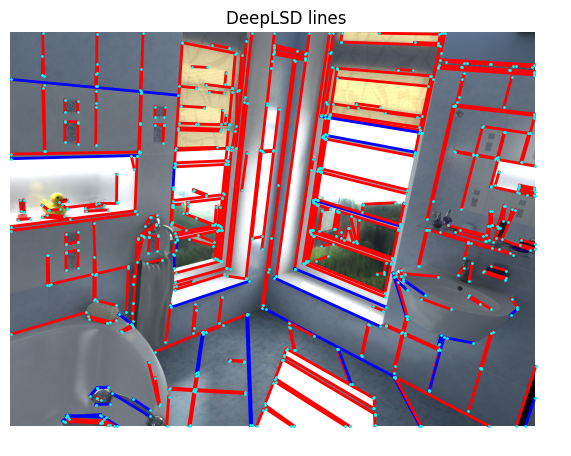

In [ ]:
import os
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import torch
import h5py
import numpy as np

from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd_inference import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines , plot_color_lines
import os
import numpy as np
import cv2
import torch
import h5py
from deeplsd.models.deeplsd_inference import DeepLSD

# Load an image from the Hypersim dataset
image_path = '../assets/data/ai_001_001/images/scene_cam_00_final_preview/frame.0001.color.jpg'
img = cv2.imread(image_path)[:, :, ::-1]
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Load depth and normal maps
depth_path = '../assets/data/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5'
normal_path = '../assets/data/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.normal_bump_world.hdf5'

with h5py.File(depth_path, 'r') as f:
    depth_map = np.array(f['dataset'])

with h5py.File(normal_path, 'r') as f:
    normal_map = np.array(f['dataset'])

depth_map = depth_map.astype(np.float32)
normal_map = normal_map.astype(np.float32)
# Initialize DeepLSD model

# Model config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {
    'detect_lines': True,  # Whether to detect lines or only DF/AF
    'line_detection_params': {
        'merge': False,  # Whether to merge close-by lines
        'filtering': True,  # Whether to filter out lines based on the DF/AF. Use 'strict' to get an even stricter filtering
        'grad_thresh': 3,
        'grad_nfa': True,  # If True, use the image gradient and the NFA score of LSD to further threshold lines. We recommand using it for easy images, but to turn it off for challenging images (e.g. night, foggy, blurry images)
    }
}

# Load the model
ckpt = '../weights/deeplsd_md.tar'
ckpt = torch.load(str(ckpt), map_location='cpu', weights_only=False)


net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()

# Detect lines
inputs = {'image': torch.tensor(gray_img, dtype=torch.float32, device=device)[None, None] / 255.}
with torch.no_grad():
    out = net(inputs)
    pred_lines = out['lines'][0]

# Function to calculate variation along a line segment
def calculate_variation(dmap, line):
    #x1, y1, x2, y2 = map(int, line)
    x1, y1, x2, y2 = int(line[0,0]), int(line[0,1]), int(line[1,0]), int(line[1,1])
    line_values = cv2.line(np.zeros_like(dmap), (x1, y1), (x2, y2), 1, 1) * dmap
    line_values = line_values[line_values != 0]
    return np.std(line_values)

def calculate_cosine_variation_normalmap(normalmap, line):
    # Extract the coordinates of the line segment
    x1, y1, x2, y2 = int(line[0, 0]), int(line[0, 1]), int(line[1, 0]), int(line[1, 1])
    
    # Generate the line mask
    line_mask = cv2.line(np.zeros_like(normalmap), (x1, y1), (x2, y2), 1, 1)
    
    # Extract the normals along the line
    normals = normalmap[line_mask == 1]
    
    
    # Calculate the cosine of the angles between consecutive normals
    #cosines = np.sum(np.dot(normals[:-1], normals[1:]), axis=1)
    n = len(normals)
    cosines = []
    for i in range(n):
        for j in range(i + 1, n):
            cosine = np.dot(normals[i], normals[j])
            cosines.append(cosine)
    
    # Calculate the variation (standard deviation) of the cosine values
    variation = np.std(cosines)
    
    return variation



threshold = 1
l1 = 10
l2 = 0
structural_lines = []
textural_lines = []

isstruct = [False] * len(pred_lines)
for i in range(len(pred_lines)):
    line = pred_lines[i]
    depth_variation = calculate_variation(depth_map, line)
    normal_variation = calculate_cosine_variation_normalmap(normal_map, line)
    if l1* depth_variation + l2 *normal_variation > threshold:
        isstruct[i] = True
        structural_lines.append(line)
    else:
        textural_lines.append(line)

print(f'Structural lines: {len(structural_lines)}')
print(f'Textural lines: {len(textural_lines)}')


def plot_lines_struct(lines, structural_lines, point_color='cyan',
               ps=4, lw=2, indices=(0, 1), alpha=1):
  
    line_colors = ['blue' if struct else 'red' for struct in structural_lines]


    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l in zip(axes, lines):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 0, 0], l[i, 1, 0]), (l[i, 0, 1], l[i, 1, 1]),
                zorder=1, c=line_colors[i], linewidth=lw, alpha=alpha)
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 0], pts[:, 1], c=point_color, s=ps,
                  linewidths=0, zorder=2, alpha=alpha)
# Plot the predictions
plot_images([img], ['DeepLSD lines'], cmaps='gray')
plot_lines_struct([pred_lines], isstruct, indices=range(1))


In [43]:

import os
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import torch
import h5py
import numpy as np

from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd_inference import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines , plot_color_lines
import os
import numpy as np
import cv2
import torch
import h5py
from deeplsd.models.deeplsd_inference import DeepLSD

# Load an image from the Hypersim dataset
image_path = '../assets/data/ai_001_001/images/scene_cam_00_final_preview/frame.0001.color.jpg'
img = cv2.imread(image_path)[:, :, ::-1]
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Load depth and normal maps
depth_path = '../assets/data/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5'
normal_path = '../assets/data/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.normal_bump_world.hdf5'

with h5py.File(depth_path, 'r') as f:
    depth_map = np.array(f['dataset'])

with h5py.File(normal_path, 'r') as f:
    normal_map = np.array(f['dataset'])

depth_map = depth_map.astype(np.float32)
normal_map = normal_map.astype(np.float32)
# Initialize DeepLSD model

# Model config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {
    'detect_lines': True,  # Whether to detect lines or only DF/AF
    'line_detection_params': {
        'merge': False,  # Whether to merge close-by lines
        'filtering': True,  # Whether to filter out lines based on the DF/AF. Use 'strict' to get an even stricter filtering
        'grad_thresh': 3,
        'grad_nfa': True,  # If True, use the image gradient and the NFA score of LSD to further threshold lines. We recommand using it for easy images, but to turn it off for challenging images (e.g. night, foggy, blurry images)
    }
}

# Load the model
ckpt = '../weights/deeplsd_md.tar'
ckpt = torch.load(str(ckpt), map_location='cpu', weights_only=False)


net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()

# Detect lines
inputs = {'image': torch.tensor(gray_img, dtype=torch.float32, device=device)[None, None] / 255.}
with torch.no_grad():
    out = net(inputs)
    pred_lines = out['lines'][0]

[03/07/2025 13:22:35 WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..8.209961169821277].


Lines depth
Lines normal


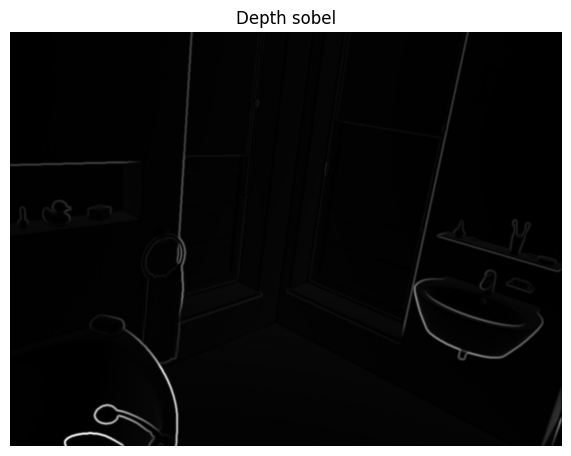

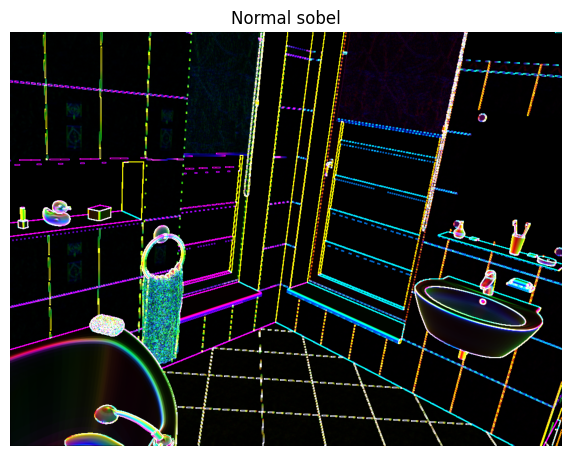

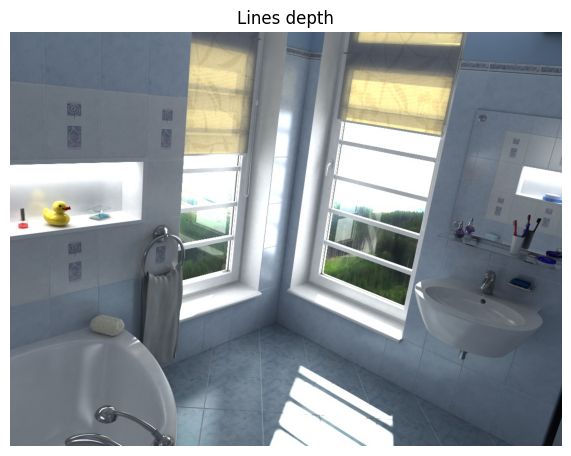

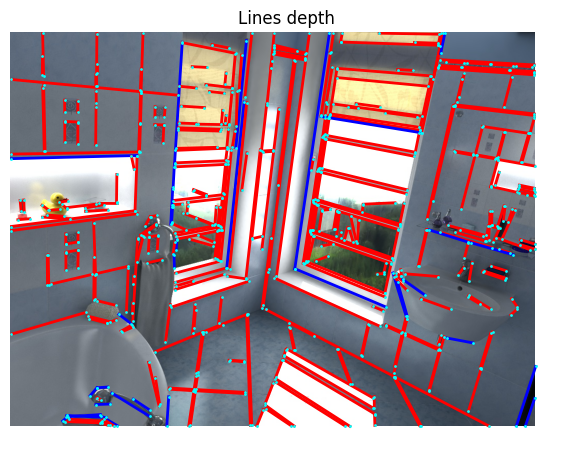

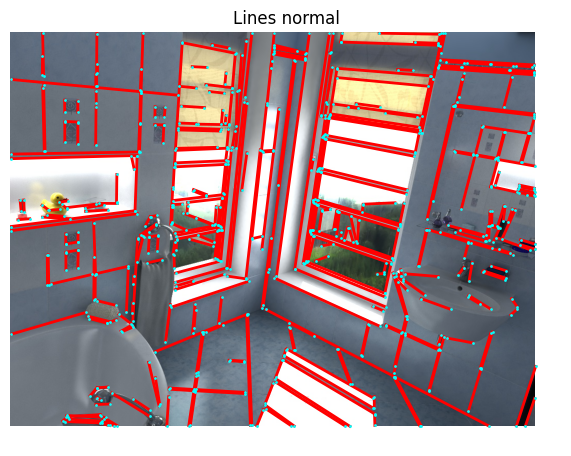

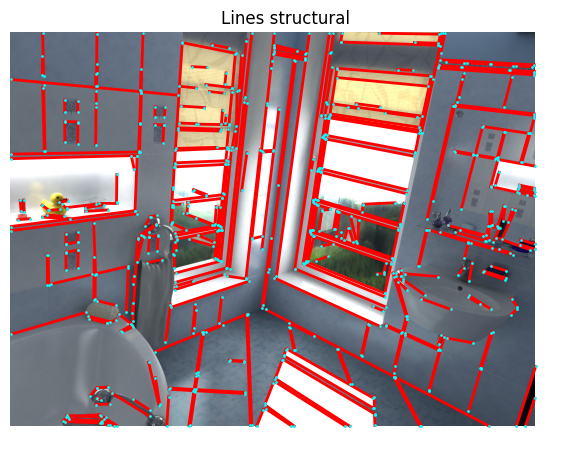

In [105]:


# Compute depth variation
def compute_variation(depth, k):
    depth_grad_x = cv2.Sobel(depth, cv2.CV_64F, 1, 0, ksize=k)
    depth_grad_y = cv2.Sobel(depth, cv2.CV_64F, 0, 1, ksize=k)
    depth_variation = np.sqrt(depth_grad_x**2 + depth_grad_y**2)
    return depth_variation
# Classify lines


sobel_depth_map = compute_variation(depth_map,11)
sobel_depth_map_min = np.min(sobel_depth_map)
sobel_depth_map_max = np.max(sobel_depth_map)
sobel_depth_map_norm = (sobel_depth_map - sobel_depth_map_min) / (sobel_depth_map_max - sobel_depth_map_min)

sobel_normal_map = compute_variation(normal_map, 3)

plot_images([sobel_depth_map], ["Depth sobel"], cmaps='gray')
plot_images([sobel_normal_map], ['Normal sobel'], cmaps='gray')

def sobel_line(sobel_depth, sobel_normal, line):
    #x1, y1, x2, y2 = map(int, line)
    x1, y1, x2, y2 = int(line[0,0]), int(line[0,1]), int(line[1,0]), int(line[1,1])
    line_values_depth = cv2.line(np.zeros_like(sobel_depth), (x1, y1), (x2, y2), 1, 1) * sobel_depth
    line_values_normal = cv2.line(np.zeros_like(sobel_normal), (x1, y1), (x2, y2), 1, 1) * sobel_normal

    return line_values_normal, line_values_depth

isdepth =[]
isnormal = []
isstruct = []
## Depth should be higher than 0.000008
for l in (pred_lines):
    sobel_normals, sobel_depths = sobel_line(sobel_depth_map_norm, sobel_normal_map, l)
    depthbool = np.mean(sobel_depths) > 0.000008
    #depthbool = np.max(sobel_depths) > 0.00000005 #or np.mean(sobel_depths) < 0.01
    normalbool = np.mean(sobel_normals) > 0.1

    isdepth.append(depthbool)
    isnormal.append(normalbool)
    isstruct.append(depthbool and normalbool)
  


def plot_lines_struct(lines, structural_lines, point_color='cyan',
               ps=4, lw=2, indices=(0, 1), alpha=1):
  
    line_colors = ['blue' if struct else 'red' for struct in structural_lines]


    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l in zip(axes, lines):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 0, 0], l[i, 1, 0]), (l[i, 0, 1], l[i, 1, 1]),
                zorder=1, c=line_colors[i], linewidth=lw, alpha=alpha)
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 0], pts[:, 1], c=point_color, s=ps,
                  linewidths=0, zorder=2, alpha=alpha)
# Plot the predictions
plot_images([img], ['Lines depth'], cmaps='gray')
print("Lines depth")
plot_images([img], ['Lines depth'], cmaps='gray')
plot_lines_struct([pred_lines], isdepth, indices=range(1))
print("Lines normal")
plot_images([img], ['Lines normal'], cmaps='gray')
plot_lines_struct([pred_lines], isnormal, indices=range(1))

plot_images([img], ['Lines structural'], cmaps='gray')
plot_lines_struct([pred_lines], isstruct, indices=range(1))

[03/07/2025 13:09:21 WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..8.209961169821277].


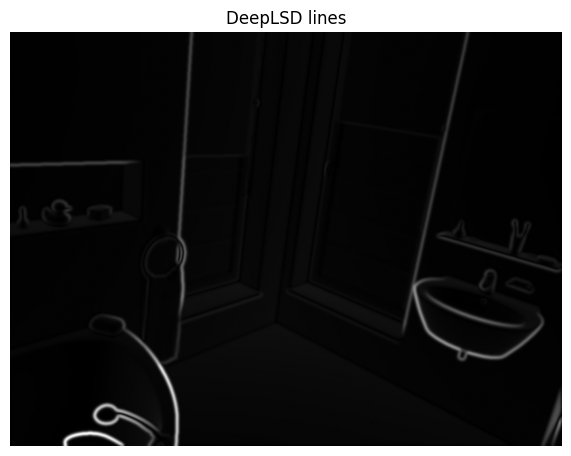

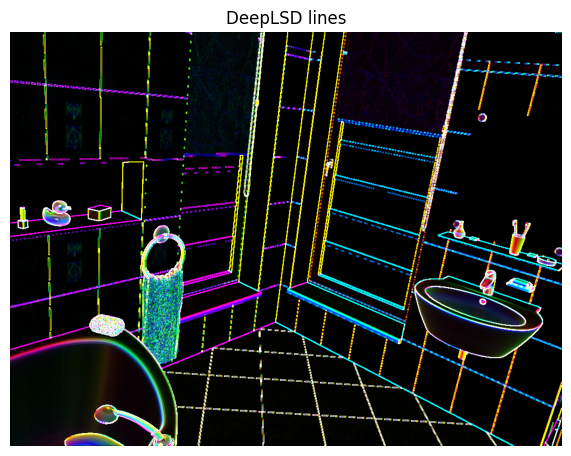

In [95]:
import os
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import torch
import h5py
import numpy as np

from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd_inference import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines , plot_color_lines
import os
import numpy as np
import cv2
import torch
import h5py
from deeplsd.models.deeplsd_inference import DeepLSD

"""
# Load an image from the Hypersim dataset
image_path = '../assets/data/ai_001_001/images/scene_cam_00_final_preview/frame.0001.color.jpg'
img = cv2.imread(image_path)[:, :, ::-1]
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Load depth and normal maps
depth_path = '../assets/data/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.depth_meters.hdf5'
normal_path = '../assets/data/ai_001_001/images/scene_cam_00_geometry_hdf5/frame.0001.normal_bump_world.hdf5'

with h5py.File(depth_path, 'r') as f:
    depth_map = np.array(f['dataset'])

with h5py.File(normal_path, 'r') as f:
    normal_map = np.array(f['dataset'])

depth_map = depth_map.astype(np.float32)
normal_map = normal_map.astype(np.float32)
# Initialize DeepLSD model

# Model config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {
    'detect_lines': True,  # Whether to detect lines or only DF/AF
    'line_detection_params': {
        'merge': False,  # Whether to merge close-by lines
        'filtering': True,  # Whether to filter out lines based on the DF/AF. Use 'strict' to get an even stricter filtering
        'grad_thresh': 3,
        'grad_nfa': True,  # If True, use the image gradient and the NFA score of LSD to further threshold lines. We recommand using it for easy images, but to turn it off for challenging images (e.g. night, foggy, blurry images)
    }
}

# Load the model
ckpt = '../weights/deeplsd_md.tar'
ckpt = torch.load(str(ckpt), map_location='cpu', weights_only=False)


net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()

# Detect lines
inputs = {'image': torch.tensor(gray_img, dtype=torch.float32, device=device)[None, None] / 255.}
with torch.no_grad():
    out = net(inputs)
    pred_lines = out['lines'][0]
"""
# Compute depth variation
def compute_depth_variation(depth, k):
    depth_grad_x = cv2.Sobel(depth, cv2.CV_64F, 1, 0, ksize=k)
    depth_grad_y = cv2.Sobel(depth, cv2.CV_64F, 0, 1, ksize=k)
    depth_variation = np.sqrt(depth_grad_x**2 + depth_grad_y**2)
    return depth_variation
# Classify lines


sobel_depth31 = compute_depth_variation(depth_map,31)
plot_images([sobel_depth31], ['DeepLSD lines'], cmaps='gray')

sobel_normal = compute_depth_variation(normal_map, 3)
plot_images([sobel_normal], ['DeepLSD lines'], cmaps='gray')
